# READ ME

This notebook aims to predict the area of law associated with each of the 100 judgements by analyzing the labeled Indian law judgement data. Some of the approaches included here are: SVM, Naive Bayes, LogisticRegression, and LDA. 

The validation F1 score across different models are quite similar and the best one is around 0.64 (Naive Bayes). 

To adjust for the imbalanced data, I tried grouping smaller area of law into ONE category, and also upsampling. 

*There might be some libraries that are not commonly used and would need to be installed such as mlxtend.

Thank you for reading. 

--Guangda (gz6xw@virginia.edu)

In [ ]:
import pandas as pd
import numpy as np
import re
import glob
import os
import spacy
import gensim
from gensim.corpora.dictionary import Dictionary
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models import CoherenceModel

import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, confusion_matrix 
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.utils import resample


import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from mlxtend.classifier import EnsembleVoteClassifier
from imblearn.over_sampling import RandomOverSampler # doctest: +NORMALIZE_WHITESPACE


In [208]:
os.getcwd()

'/sfs/lustre/bahamut/scratch/gz6xw/rule14/Sample Problem/Fixed Judgements'

In [ ]:
#adjust working directory accordingly
os.chdir("./Fixed Judgements")

# Data Preprocessing

In [211]:
def clean(sentences):
    nlp = spacy.load('en')
    docs = [nlp(s) for s in sentences]
    processed_text = []
    for doc in docs:
        lemmas = []
        for token in doc:
            if not token.is_punct and token.lemma_ != '-PRON-':
                lemmas.append(token.lemma_)
            if token.lemma_ == '-PRON-' and token.is_alpha:
                lemmas.append(token.text)
            elif token.lemma_ == '-PRON-' and token.text == '’s':
                lemmas.append('us')
        processed_text.append(' '.join(lemmas))
    return processed_text

In [212]:
all_doc=pd.DataFrame()

for files in glob.glob("*.txt"):
    
    lines = open(files, 'r', encoding = 'Latin-1').readlines()
    
    file, extension = files.split('.')
    df = pd.DataFrame(lines, columns=[file])
    
    #grab lines after judgements
    a = df[file].str.match(r"^.*(Judgment).*$")
    an = df.loc[a +1].index[0] 
    df = df.loc[an : ]
        
    #merge all sentences into one row
    df = df.apply(' '.join).reset_index() 
    
    all_doc = pd.concat([all_doc,df],axis=0) 


In [210]:
# lemmatizer
lemmatizer = WordNetLemmatizer()

# spacy model
nlp = spacy.load("en")

# function to lemmatize a given word
def lemmatize(text):
    return lemmatizer.lemmatize(text, pos = "n")

# function to preprocess the text
def preprocess(text):
    result = ''
    for word in gensim.utils.simple_preprocess(text):
        if word not in gensim.parsing.preprocessing.STOPWORDS and len(word) > 3:

        #if len(word) > 3:
            l = lemmatize(word)
            if len(l) > 3:
                result = result + ' ' + l.lower()
    return result

In [213]:
all_doc.reset_index(drop = True, inplace = True)
all_doc.columns = ["Judgements", "text"]
#all_doc['text'] = clean(all_doc['text'])

#all_doc['text'] =  [re.sub('<.*?>|\\\n|[^A-Za-z ]+','', str(x)) for x in all_doc['text']]
all_doc['processed_text'] = all_doc.text.map(preprocess)# do not remove stopwords since using tf-idf
#all_doc

In [214]:
#add in the labels to judgement table
labels = pd.read_csv('../Interview_Mapping.csv')
all_doc2 = pd.merge(all_doc, labels, how = 'left', on = 'Judgements')
all_doc2.head()

,Judgements,text,processed_text,Area.of.Law
0,LNIND_1954_CAL_1,\n Parties\n Bepin Behari Ghanti Versus Mohamm...,party bepin behari ghanti versus mohammad hos...,Tenancy Laws
1,LNIND_1979_CAL_184,Parties\n Gobindlal Bangur Versus Wealth-tax O...,party gobindlal bangur versus wealth officer ...,Income Tax
2,LNIND_1980_CAL_226,Commissioner of Income-tax Versus C.L. Bajoria...,commissioner income versus bajoria high court...,To be Tested
3,LNIND_1952_CAL_114,\n <LG> Original Side Rules </LG>\n <PV>Chapt...,original rule chapter rule party good kumar b...,To be Tested
4,LNIND_1980_CAL_84,Parties\n Jute Corporation of India Ltd Versus...,party jute corporation india versus commissio...,Income Tax


# DATA EXPLORATORY

In [215]:
area_count = all_doc2[['Judgements', 'Area.of.Law']].groupby('Area.of.Law').agg('count').sort_values('Judgements', ascending = False).reset_index()
#area_count # 42 unique domains

Text(0.5, 0, 'Area.of.Law')

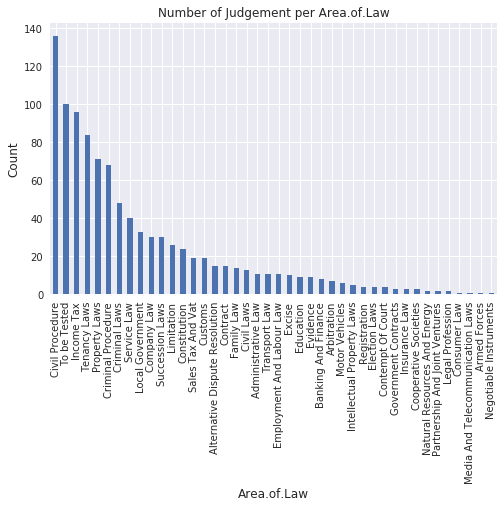

In [216]:
area_count.plot(x='Area.of.Law', y='Judgements', kind='bar', legend=False, grid=True, figsize=(8, 5))
plt.title("Number of Judgement per Area.of.Law")
plt.ylabel('Count', fontsize=12)
plt.xlabel('Area.of.Law', fontsize=12)

From the above grah we can see a clear left skewed distribution and imbalance within the dataset. Certain areas of law such as 'Consumer Law' is only associating to one document, while other areas could have as many as 136. Such discrepancy in the size of each category makes needs to be considered when training models. To adjust this issue, I tried the following methods:

1)Group topics that have less than 15 documents into ONE category 'others'

2)Upsample the training dataset

In [217]:
#split into train and test
test = all_doc2[all_doc2['Area.of.Law'] == 'To be Tested']
train = all_doc2[all_doc2['Area.of.Law'] != 'To be Tested']

In [218]:
x_test = test['processed_text']

In [219]:
#Further split train into validation
#stratify = train['Area.of.Law'], 
x_train, x_validation, y_train, y_validation = train_test_split(train['processed_text'],train['Area.of.Law'],test_size = 0.2, random_state=0)

# 1) - Category 'others' for imbalanced data

In [268]:
#train data
train2 = pd.concat([x_train, y_train],axis=1)
train2.sample(2)

,processed_text,Area.of.Law
210,nani versus satyendra nath high court judicat...,Contract
486,west bengal premise tenancy section party ver...,Tenancy Laws


In [221]:
#For topics that have less than 15 documents, merge into 'others'
others = area_count[area_count['Judgements'] < 25]['Area.of.Law'].to_list()
others

['Constitution',
 'Sales Tax And Vat',
 'Customs',
 'Alternative Dispute Resolution',
 'Contract',
 'Family Law',
 'Civil Laws',
 'Administrative Law',
 'Transport Law',
 'Employment And Labour Law',
 'Excise',
 'Education',
 'Evidence',
 'Banking And Finance',
 'Arbitration',
 'Motor Vehicles',
 'Intellectual Property Laws',
 'Registration',
 'Election Laws',
 'Contempt Of Court',
 'Government Contracts',
 'Insurance Law',
 'Cooperative Societies',
 'Natural Resources And Energy',
 'Partnership And Joint Ventures',
 'Legal Profession',
 'Consumer Law',
 'Media And Telecommunication Laws',
 'Armed Forces',
 'Negotiable Instruments']

In [223]:
train2.loc[train2['Area.of.Law'].isin(others), 'Area.of.Law'] = 'Others' 
train2.sample(2)

,processed_text,Area.of.Law
990,corporation calcutta versus trading high cour...,Criminal Procedure
522,panchanan ghose versus haridas banerjee high ...,Tenancy Laws


In [224]:
train2['Area.of.Law'].nunique()

12

After grouping small subgroups together, there are only 12 unique areas of law left in the training set, which seems like a large drop from the original 42 areas. However, after comparing the results with and without this grouping, we can see that the prediction with grouping 'others' is actually higher (0.64 v.s 0.58). This might be due to the low proportion of judgements associated with these labels in the validation data. 

In [225]:
x_train2 = train2['processed_text']
y_train2 = train2['Area.of.Law']

# 2) - Upsampling for imbalanced data

In [228]:
train3 = pd.concat([x_train, y_train],axis=1)
#train3

In [229]:
x = pd.DataFrame(x_train)
y = pd.DataFrame(y_train)

In [230]:
oversample = RandomOverSampler()
x, y = oversample.fit_resample(x, y)

In [231]:
train_up = pd.concat([x, y],axis=1)
train_up.sample(3)

,processed_text,Area.of.Law
1898,party jessops operative society versus regist...,Cooperative Societies
981,party rajputana trading versus jute gunny bro...,Arbitration
2123,latika sharma sarkar versus university calcut...,Education


Upsampling by resampling all minority documents to match the count of the majority seems to distort the data too much in this case and does not provide a better prediction score. I then decided to move on with previous ways of dealing with imbalanced data. 

# Embedding

In [232]:
#CountVectorizer
vect = CountVectorizer(stop_words='english').fit(x_train2)
X_train_vectorized = vect.transform(x_train2)
X_validation_vectorized = vect.transform(x_validation) #same # for val
X_test_vectorized = vect.transform(x_test) #same # for val


In [233]:
#tf-idf
tfidf_vectorizer=TfidfVectorizer(use_idf=True).fit(x_train2)
x_train_tfidf=tfidf_vectorizer.transform(x_train2)
x_val_tfidf=tfidf_vectorizer.transform(x_validation)

# Model Training

From high level, evaluate three of the most common techniques for text classification. 

In [ ]:
models = [
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, X_train_vectorized, y_train, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

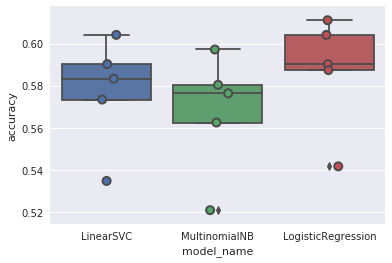

In [235]:
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

LogisticRegression seems to be slightly better than the other two. In the following section, I then performed each of these models with gridsearch and ensembling. 

# Model 1: Logistic Regression

In [ ]:
model_logistic = LogisticRegression(random_state=0).fit(X_train_vectorized, y_train)
preds_logistic = model_logistic.predict(X_validation_vectorized)
score = accuracy_score(preds_logistic, y_validation)
print("Logistic - Count Vector: ", score)

In [237]:
# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = np.logspace(0, 4, 10)

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)

In [ ]:
clf = GridSearchCV(model_logistic, hyperparameters, cv=5, verbose=0)
# Fit grid search
best_model = clf.fit(X_train_vectorized, y_train)

In [239]:
# View best hyperparameters
print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])

Best Penalty: l2
Best C: 1.0


In [240]:
logistic_grid_pred = best_model.predict(X_validation_vectorized)

In [241]:
score = accuracy_score(logistic_grid_pred, y_validation)
print("Logistic - Count Vector: ", score)

Logistic - Count Vector:  0.6


In [242]:
print(classification_report(y_validation, logistic_grid_pred)) 

                                precision    recall  f1-score   support

            Administrative Law       0.00      0.00      0.00         1
Alternative Dispute Resolution       0.50      0.67      0.57         3
                   Arbitration       0.50      0.50      0.50         2
           Banking And Finance       0.00      0.00      0.00         2
                    Civil Laws       1.00      0.33      0.50         3
               Civil Procedure       0.50      0.62      0.55        29
                   Company Law       0.25      0.20      0.22         5
                  Constitution       0.43      0.60      0.50         5
             Contempt Of Court       1.00      0.50      0.67         2
                      Contract       0.50      0.60      0.55         5
                 Criminal Laws       0.47      0.80      0.59        10
            Criminal Procedure       0.64      0.54      0.58        13
                       Customs       0.00      0.00      0.00  

/home/gz6xw/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gz6xw/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gz6xw/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


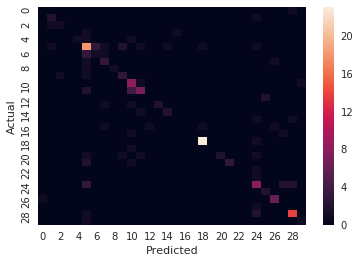

In [243]:
conf = confusion_matrix(y_validation, logistic_grid_pred)
sns.heatmap(conf)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# MODEL 2 - Native Bayes

In [244]:
clfrNB = MultinomialNB(alpha = 0.1)
clfrNB.fit(x_train_tfidf, y_train)
preds = clfrNB.predict(x_val_tfidf)
score = accuracy_score(preds, y_validation)
print("Naive Bayes - tfidf: ", score)

Naive Bayes - tfidf:  0.4


In [245]:
model_NB = MultinomialNB(alpha = 0.1)
model_NB.fit(X_train_vectorized, y_train)
preds = model_NB.predict(X_validation_vectorized)
score = accuracy_score(preds, y_validation)
print("Naive Bayes - Count Vectors Accuracy: ", score)


Naive Bayes - Count Vectors Accuracy:  0.6388888888888888


CountVector seems to work better than tfidf in this situation

In [246]:
model_NB.get_params().keys()

dict_keys(['alpha', 'class_prior', 'fit_prior'])

In [ ]:
#Grid Search
param_grid = {'alpha': [1, 0.1, 0.01, 0.001, 0.0001],
                     'fit_prior': [True, False]}
              
grid = GridSearchCV(model_NB, param_grid, refit = True, verbose = 3) 
  
# fitting the model for grid search 
grid.fit(X_train_vectorized, y_train) 

In [248]:
grid_predictions = grid.predict(X_validation_vectorized) 

score = accuracy_score(grid_predictions, y_validation)
score

0.6388888888888888

In [249]:
#f1 score and other evluations
print(classification_report(y_validation, preds)) 

                                precision    recall  f1-score   support

            Administrative Law       0.00      0.00      0.00         1
Alternative Dispute Resolution       0.38      1.00      0.55         3
                   Arbitration       0.00      0.00      0.00         2
           Banking And Finance       1.00      0.50      0.67         2
                    Civil Laws       1.00      0.33      0.50         3
               Civil Procedure       0.55      0.76      0.64        29
                   Company Law       0.50      0.40      0.44         5
                  Constitution       0.50      0.60      0.55         5
             Contempt Of Court       0.00      0.00      0.00         2
                      Contract       0.25      0.20      0.22         5
                 Criminal Laws       0.62      0.80      0.70        10
            Criminal Procedure       0.82      0.69      0.75        13
                       Customs       1.00      1.00      1.00  

/home/gz6xw/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gz6xw/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gz6xw/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


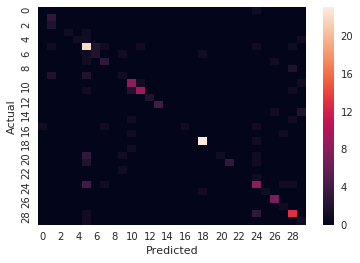

In [250]:
conf = confusion_matrix(y_validation, preds)
sns.heatmap(conf)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [251]:
'''
a = pd.DataFrame(preds)
b = pd.DataFrame(y_validation).reset_index()
c = pd.concat([a, b], axis=1)
c.columns = ['pred_label', 'index', 'actual_label']

c['result'] = c.pred_label == c.actual_label
c

'''

"\na = pd.DataFrame(preds)\nb = pd.DataFrame(y_validation).reset_index()\nc = pd.concat([a, b], axis=1)\nc.columns = ['pred_label', 'index', 'actual_label']\n\nc['result'] = c.pred_label == c.actual_label\nc\n\n"

# MODEL 3 - SVM

In [252]:
model_svm = svm.SVC(gamma='auto')
model_svm.fit(X_train_vectorized, y_train)
preds = model_svm.predict(X_validation_vectorized)
score = accuracy_score(preds, y_validation)

print("SVM, N-Gram Vectors: ", score)

SVM, N-Gram Vectors:  0.48333333333333334


In [ ]:
#Grid Search
param_grid = {'kernel': ['rbf', 'linear', 'poly'], 
                     'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                     'C': [1, 10, 100, 1000]}
              
grid = GridSearchCV(model_svm, param_grid, refit = True, verbose = 3) 
  
# fitting the model for grid search 
grid.fit(X_train_vectorized, y_train) 

In [254]:
grid_predictions = grid.predict(X_validation_vectorized) 
  
# print classification report 
print(classification_report(y_validation, grid_predictions))

                                precision    recall  f1-score   support

            Administrative Law       0.20      1.00      0.33         1
Alternative Dispute Resolution       0.50      0.67      0.57         3
                   Arbitration       0.25      0.50      0.33         2
           Banking And Finance       0.00      0.00      0.00         2
                    Civil Laws       0.50      0.33      0.40         3
               Civil Procedure       0.47      0.55      0.51        29
                   Company Law       0.25      0.20      0.22         5
                  Constitution       0.50      0.80      0.62         5
             Contempt Of Court       0.00      0.00      0.00         2
                      Contract       0.29      0.40      0.33         5
         Cooperative Societies       0.00      0.00      0.00         0
                 Criminal Laws       0.47      0.80      0.59        10
            Criminal Procedure       0.75      0.46      0.57  

/home/gz6xw/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gz6xw/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gz6xw/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gz6xw/.local/lib/python3.6/site-packages/skle

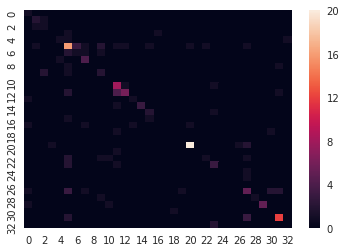

In [255]:
conf = confusion_matrix(y_validation, grid_predictions)
sns.heatmap(conf);

In [256]:
score = accuracy_score(grid_predictions, y_validation)
score

0.5277777777777778

# Ensemble

In [257]:
eclf = EnsembleVoteClassifier(clfs=[model_NB, model_svm], weights=[1,1, 1])

In [258]:

labels = ['NB', 'SVM','Ensemble']
for clf, label in zip([model_NB, model_svm, eclf], labels):

    scores = model_selection.cross_val_score(clf, X_train_vectorized, y_train, 
                                              cv=5, 
                                              scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" 
          % (scores.mean(), scores.std(), label))

/home/gz6xw/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Accuracy: 0.60 (+/- 0.02) [NB]


/home/gz6xw/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Accuracy: 0.44 (+/- 0.02) [SVM]
Accuracy: nan (+/- nan) [Ensemble]


/home/gz6xw/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/gz6xw/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Number of classifiers and weights must be equal; got 3 weights, 2 clfs

  FitFailedWarning)


# Exploratory - LDA for 'others'

In [259]:
token = all_doc2['processed_text'].str.split(' ')
dictionary = Dictionary(token)#for unique words
n_topic = all_doc2['Area.of.Law'].nunique() -1 #subtracting 'to be tested' -17

In [260]:
bow = [dictionary.doc2bow(text) for text in token] 
tfidf = gensim.models.TfidfModel(bow)
corpus = tfidf[bow]
ldamodel = gensim.models.ldamodel.LdaModel(corpus = corpus, num_topics = n_topic, id2word = dictionary, alpha = 'symmetric',
                                      random_state = 5)

In [261]:
b = dictionary.doc2bow(token[1])#property
for i, score in sorted(ldamodel[b], key = lambda x: -1*x[1]):
        print("\nScore: {}\nTopic {}: {}".format(round(score,4), i, ldamodel.print_topic(i,10)))



Score: 0.6279000043869019
Topic 16: 0.002*"assessee" + 0.002*"income" + 0.002*"assessment" + 0.001*"defendant" + 0.001*"rent" + 0.001*"company" + 0.001*"plaintiff" + 0.001*"business" + 0.001*"tenant" + 0.001*"capital"

Score: 0.1858000010251999
Topic 19: 0.001*"rent" + 0.001*"petitioner" + 0.001*"company" + 0.001*"income" + 0.001*"assessment" + 0.001*"code" + 0.001*"police" + 0.001*"contempt" + 0.001*"raiyat" + 0.001*"decree"

Score: 0.06120000034570694
Topic 23: 0.002*"income" + 0.002*"assessee" + 0.001*"tribunal" + 0.001*"company" + 0.001*"school" + 0.001*"director" + 0.001*"managing" + 0.001*"depreciation" + 0.001*"gold" + 0.001*"profit"

Score: 0.028599999845027924
Topic 10: 0.002*"tribunal" + 0.002*"suit" + 0.002*"plaintiff" + 0.002*"defendant" + 0.001*"assessee" + 0.001*"delhi" + 0.001*"summons" + 0.001*"bhatinda" + 0.001*"company" + 0.001*"appellant"

Score: 0.016200000420212746
Topic 29: 0.001*"valuation" + 0.001*"assessee" + 0.001*"defendant" + 0.001*"plaintiff" + 0.001*"shar

In [262]:
cm_spacy = CoherenceModel(model = ldamodel, texts = token, dictionary = dictionary)
cm_spacy.get_coherence()

0.38144037768874095

In [263]:
ldamodel.get_document_topics(b) # topic number

[(1, 0.01607714),
 (10, 0.028629921),
 (11, 0.013131957),
 (13, 0.01114244),
 (16, 0.6278982),
 (19, 0.1858463),
 (23, 0.061164986),
 (25, 0.0123156905),
 (27, 0.016016303),
 (29, 0.016214553)]

# Final Prediction

In [ ]:
#Predict on test data using Naive Bayes Model
test['Area.of.Law'] = model_NB.predict(X_test_vectorized)

In [271]:
results = test[['Judgements', 'Area.of.Law']]

In [273]:
results.to_csv('../Zhu_Guangda_results.csv', index= False)

Thank you for reading this document!